<a href="https://colab.research.google.com/github/nzungizelab/Genomic-Surveillance-Malaria-Vectors_Africa/blob/NzungizeL/Workshop_5_Module_1_PAMCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Module 1 - Xarray datasets** [Link](https://anopheles-genomic-surveillance.github.io/workshop-5/module-1-xarray.html)

In [ ]:
!pip install -q --no-warn-conflicts malariagen_data rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.5/302.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import malariagen_data
import xarray as xr
import numpy as np
# configure plotting with matplotlib
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0
Results cache           : None
Cohorts analysis        : 20230516
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 7.12.0
Client location         : South Carolina, US
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

#multidimensional arrays
Xarray is designed for situations where you have more than one multidimensional data array that you need to manage and access. To illustrate a situation where this is useful, consider the following image, which shows data from a geostatistical model of insecticide-treated net (ITN) use in Africa:

In [ ]:
#Anatomy of an xarray Dataset
def load_itn_metrics():

    # need to combined data from multiple tifs, requires rioxarray
    datasets = []
    years = np.arange(2000, 2021)
    file_paths = {
        "itn_access_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Access_mean.zip/ITN_{year}_access_mean.tif",
        "itn_per_capita_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Percapita_Nets_mean.zip/ITN_{year}_percapita_nets_mean.tif",
        "itn_use_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Use_mean.zip/ITN_{year}_use_mean.tif",
        "itn_use_rate_mean": "https://storage.googleapis.com/malariagen-reference-data-us/malariaatlas/2020_Africa_ITN_Use_Rate_mean.zip/ITN_{year}_use_rate_mean.tif",
    }
    for variable_name, file_path_template in file_paths.items():
        ds = (
            xr.open_mfdataset(
                paths=[file_path_template.format(year=year) for year in range(2000, 2021)],
                engine="rasterio",
                combine="nested",
                concat_dim="year",
            )
            .rename_dims({"x": "lon", "y": "lat"})
            .rename_vars({"x": "lon", "y": "lat", "band_data": variable_name})
            .isel(band=0)
            .drop_vars(["band", "spatial_ref"])
        )
        # delete attributes, the statistics don't seem to be correct
        ds[variable_name].attrs.clear()
        # add a year coordinate variable
        ds.coords["year"] = "year", years
        datasets.append(ds)

    # merge all datasets, assume already aligned
    ds_itn = xr.merge(
        datasets,
        compat="override",
        join="override",
    )

    # add metadata
    ds_itn.attrs["title"] = "Maps and metrics of insecticide-treated net access, use, and nets-per-capita in Africa from 2000-2020"
    ds_itn.attrs["creator"] = "The Malaria Atlas Project"
    ds_itn.attrs["references"] = "https://malariaatlas.org/research-project/metrics-of-insecticide-treated-nets-distribution/"

    return ds_itn

In [ ]:
ds_itn = load_itn_metrics()

In [ ]:
#This function returns an xarray Dataset, which we’ve assigned to the variable ds_itn.
type(ds_itn)

xarray.core.dataset.Dataset

In [ ]:
#get a useful representation of the dataset by typing the name of the variable at the end of a cell and running it.
ds_itn

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 21)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

This dataset has three dimensions, named “lon” (short for longitude), “lat” (short for latitude) and “year”.

The length of the lon dimension is 1681, the length of the lat dimension is 1741, and the length of the year dimension is 21. Thus we have data in a spatial grid of 1681 x 1741 squares, for 21 years.

There are four data variables named “itn_access_mean”, “itn_per_capita_mean”, “itn_use_mean” and “itn_use_rate_mean”. These are all 3-dimensional arrays, with year as the first dimension, lat as the second dimension and lon as the third dimension. The data values are floating point numbers (the array has a float32 dtype).

There are three coordinate variables named “lon”, “lat” and “year”. These each store the coordinate values for the corresponding dimension of the same name.

There are some metadata attributes giving information about the title, creator and references for the dataset.

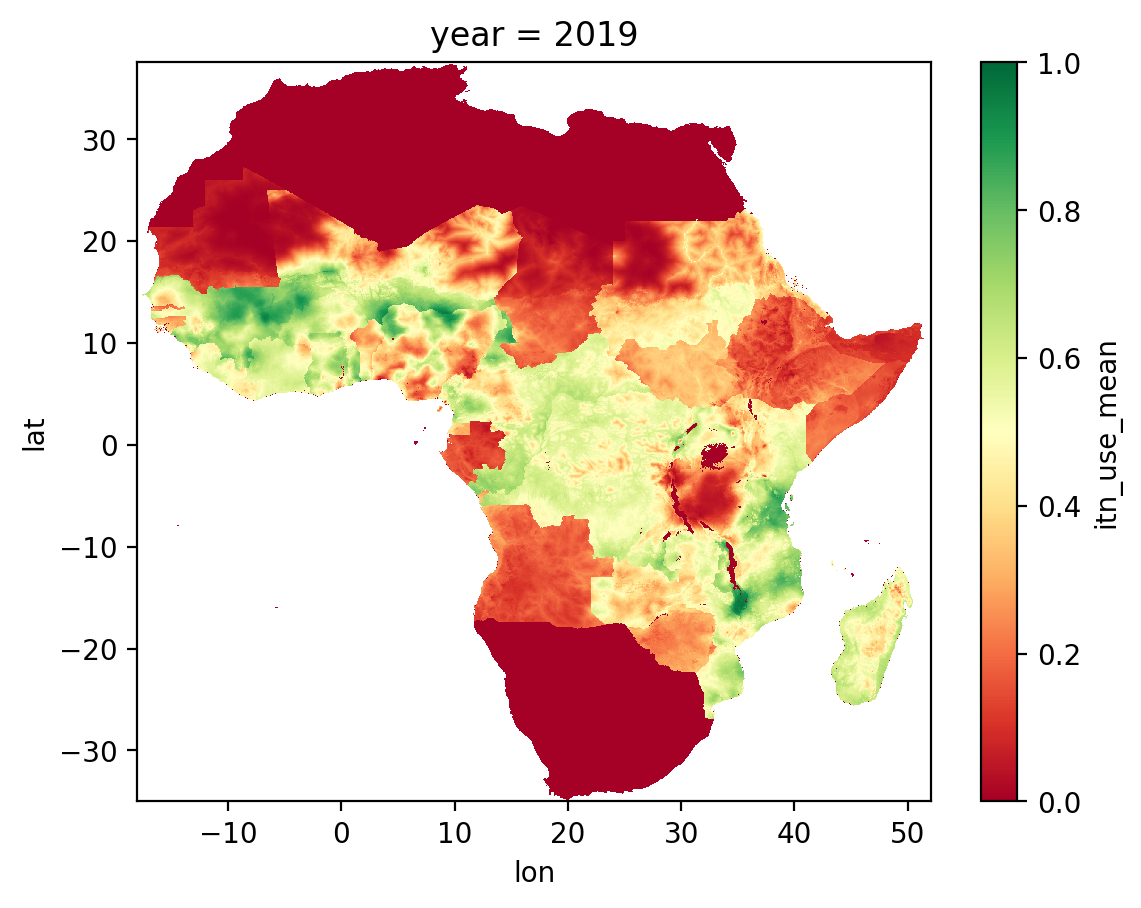

In [ ]:
# let’s plot the itn_use_mean variable for the year 2019
ds_itn.sel(year=2019)["itn_use_mean"].plot(vmin=0, vmax=1, cmap="RdYlGn");

In [ ]:
#To access a data variable, use the square bracket notation, and provide the name of the variable as a string
itn_use_mean = ds_itn["itn_use_mean"]

In [ ]:
#Let’s inspect the type of object that’s returned when we access a data variable from an xarray Dataset.
type(itn_use_mean)

xarray.core.dataarray.DataArray

In [ ]:
# This type of object has many similarities with a numpy array. E.g., it has a number of dimensions:
itn_use_mean.ndim

3

In [ ]:
#It has a shape:
itn_use_mean.shape

(21, 1741, 1681)

In [ ]:
#It has a data type:
itn_use_mean.dtype

dtype('float32')

In [ ]:
#There are also some extra features which a numpy array doesn’t have. E.g., the dimensions are named:
itn_use_mean.dims

('year', 'lat', 'lon')

In [ ]:
#We can also view a representation of this DataArray:
itn_use_mean

<xarray.DataArray 'itn_use_mean' (year: 21, lat: 1741, lon: 1681)>
dask.array<getitem, shape=(21, 1741, 1681), dtype=float32, chunksize=(1, 1741, 1681), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -17.98 -17.94 -17.9 -17.85 ... 51.9 51.94 51.98 52.02
  * lat      (lat) float64 37.52 37.48 37.44 37.4 ... -34.85 -34.9 -34.94 -34.98
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2016 2017 2018 2019 2020

In [ ]:
#We can always convert an xarray DataArray into a numpy array by accessing the .values property:
a = itn_use_mean.values

In [ ]:
type(a)

numpy.ndarray

In [ ]:
np.nanmax(a)

0.98126787

In [ ]:
np.nanmin(a)

0.0

In [ ]:
np.nanmean(a)

0.14171119

In [ ]:
np.nanstd(a)

0.2022658

**Coordinate variables**

In [ ]:
#Coordinate variables can be accessed in exactly the same way as data variables. E.g., let’s access the lon coordinate variable:
longitude = ds_itn["lon"]

In [ ]:
#This also returns an xarray DataArray:
type(longitude)

xarray.core.dataarray.DataArray

In [ ]:
#Let’s look at the representation:
longitude

<xarray.DataArray 'lon' (lon: 1681)>
array([-17.979231, -17.937565, -17.895898, ...,  51.937407,  51.979074,
        52.020741])
Coordinates:
  * lon      (lon) float64 -17.98 -17.94 -17.9 -17.85 ... 51.9 51.94 51.98 52.02

In [ ]:
#we can convert this xarray DataArray into a numpy array if we want to, by using the .values property:
longitude.values

array([-17.97923147, -17.93756482, -17.89589817, ...,  51.93740722,
        51.97907388,  52.02074053])

**Selecting data with indexing**

In [ ]:
#One of the main benefits of xarray is the ability to select data from a particular point or region along one or more dimensions.
#let’s remind ourselves what the ITN metrics dataset looks like:
ds_itn

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 21)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001 2002 2003 ... 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

In [ ]:
#Positional indexing with isel()
ds_itn_y0 = ds_itn.isel(year=0)
ds_itn_y0

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
    year                 int64 2000
Data variables:
    itn_access_mean      (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_mean         (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

In [ ]:
#lets select a range of years, e.g., the first two years, by providing a slice:
ds_itn_y02 = ds_itn.isel(year=slice(0, 2))
ds_itn_y02

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 2)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2000 2001
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

**Label-based indexing with sel()**

In [ ]:
#it is more convenient to make selections using the coordinates themselves
#if we are interested in data from the year 2020, it is easier to ask for that directly. We can do that with xarray by using the .sel() method:
ds_itn_2020 = ds_itn.sel(year=2020)
ds_itn_2020

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
    year                 int64 2020
Data variables:
    itn_access_mean      (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_mean         (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (lat, lon) float32 dask.array<chunksize=(1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

As we have selected data from 2020, let’s now make a rough-and-ready reproduction of Figure 3 from Bertozzi-Villa et al. (2021). Xarray includes some built-in plotting functionality, which we are making use of here by calling the .plot() method. The cmap parameter provides a colour map to convert the data values into colours. I’ve chosen colour maps to try and match the original figure from the paper.

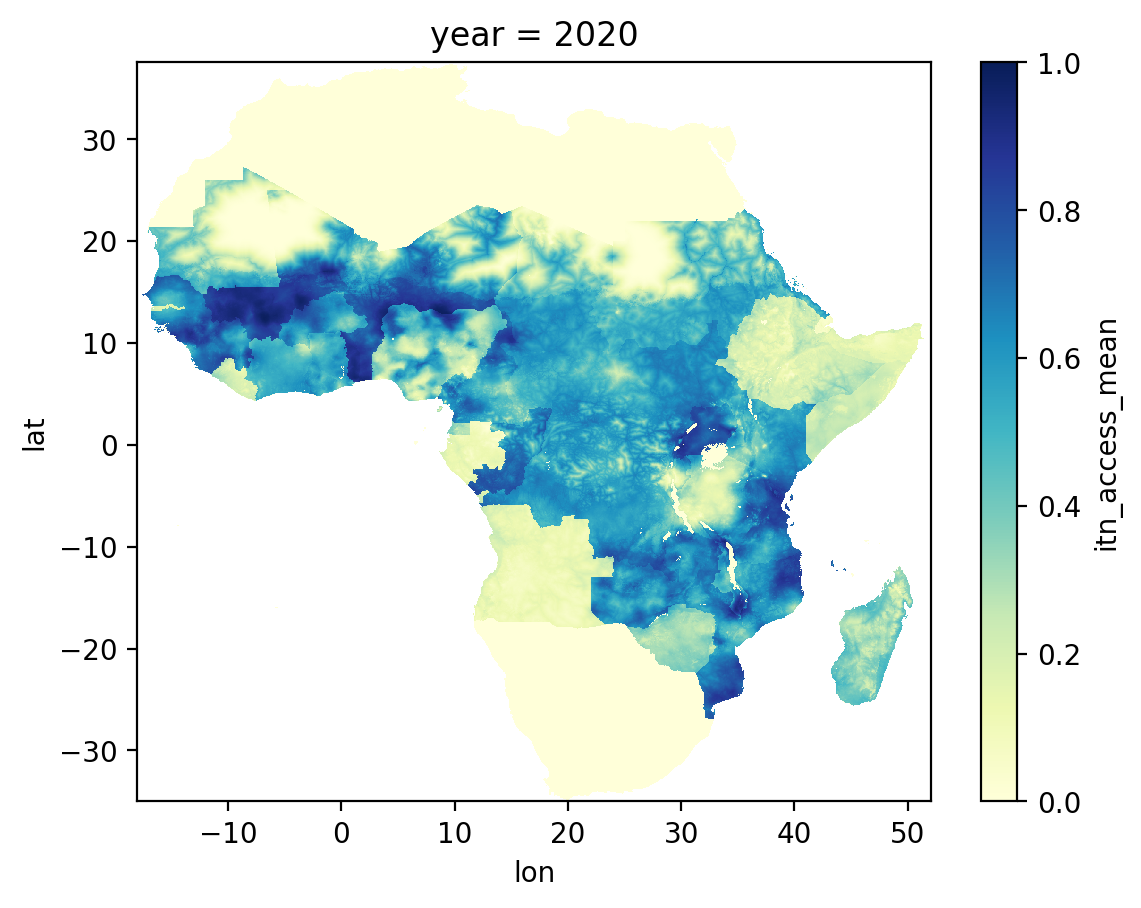

In [ ]:
ds_itn_2020["itn_access_mean"].plot(vmin=0, vmax=1, cmap="YlGnBu");

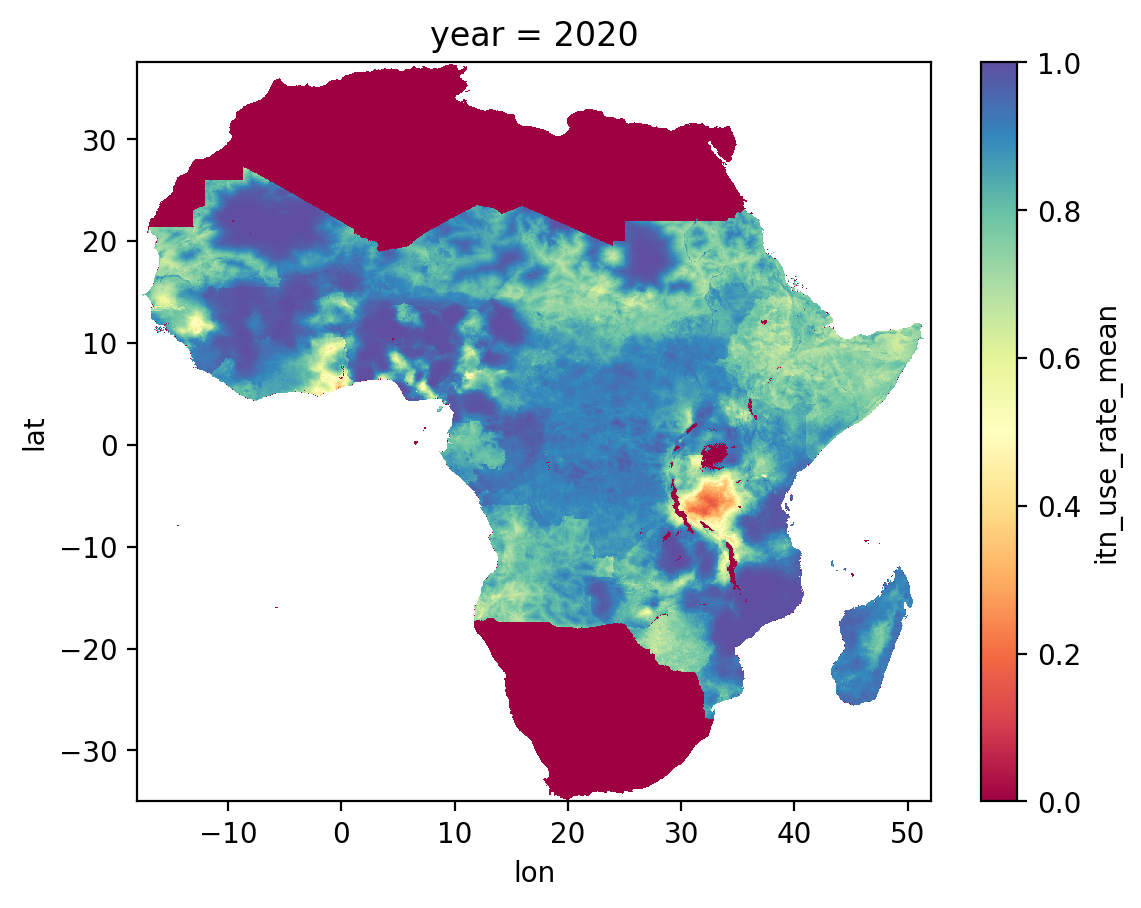

In [ ]:
ds_itn_2020["itn_use_rate_mean"].plot(vmin=0, vmax=1, cmap="Spectral");

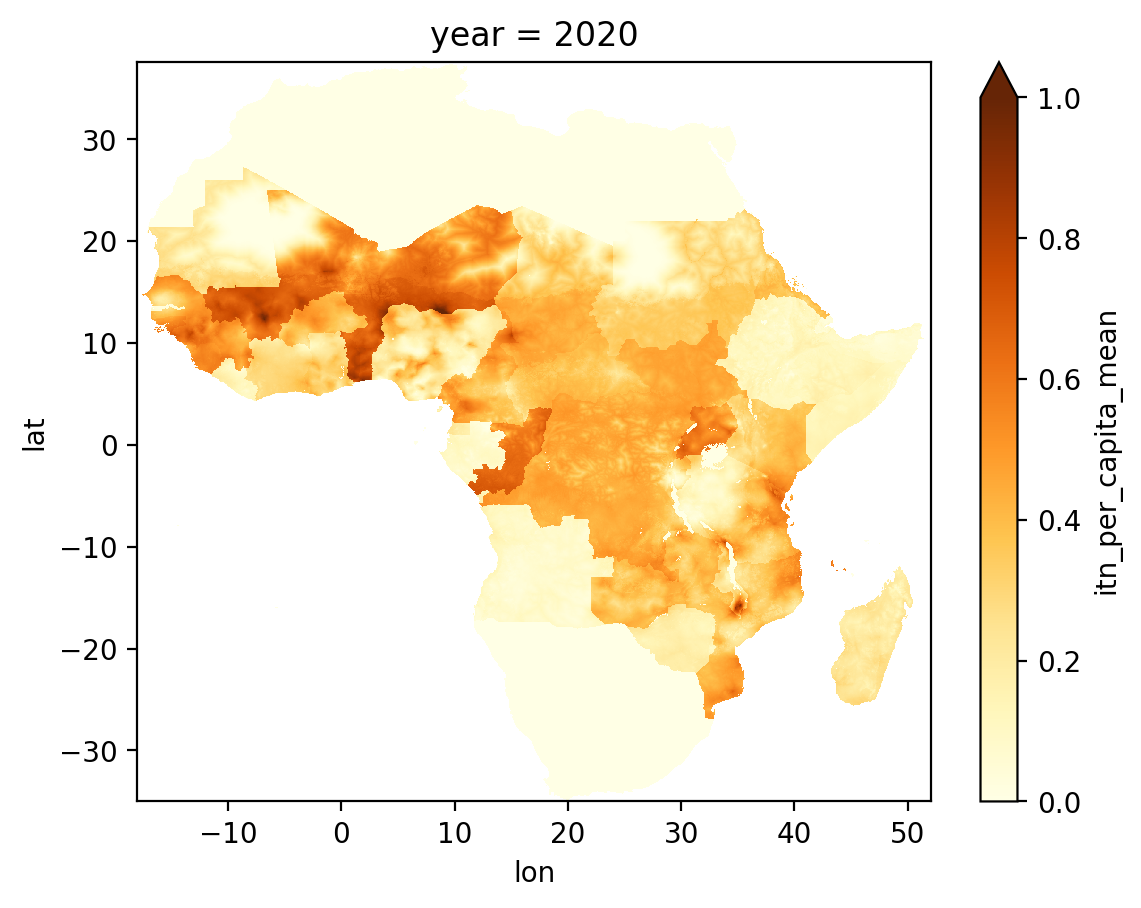

In [ ]:
ds_itn_2020["itn_per_capita_mean"].plot(vmin=0, vmax=1, cmap="YlOrBr");

In [ ]:
#You can also select data for a range of years. E.g., select data from 2018 to 2020.
ds_itn_2018_2020 = ds_itn.sel(year=slice(2018, 2020))
ds_itn_2018_2020

<xarray.Dataset>
Dimensions:              (lon: 1681, lat: 1741, year: 3)
Coordinates:
  * lon                  (lon) float64 -17.98 -17.94 -17.9 ... 51.94 51.98 52.02
  * lat                  (lat) float64 37.52 37.48 37.44 ... -34.9 -34.94 -34.98
  * year                 (year) int64 2018 2019 2020
Data variables:
    itn_access_mean      (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_per_capita_mean  (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_mean         (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
    itn_use_rate_mean    (year, lat, lon) float32 dask.array<chunksize=(1, 1741, 1681), meta=np.ndarray>
Attributes:
    title:       Maps and metrics of insecticide-treated net access, use, and...
    creator:     The Malaria Atlas Project
    references:  https://malariaatlas.org/research-project/metrics-of-insecti...

**Uses of xarray for genomic data**

#SNP calls

In [ ]:
#We use an xarray Dataset for a set of SNP calls. E.g., access SNP calls for all available samples and for chromosome arm 3R:
ds_snp = ag3.snp_calls(
    region="3R"
)
ds_snp

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4,
                                         samples: 3081, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    sample_id                           (samples) <U24 dask.array<chunksize=(81,), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, samples, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, samples, ploidy) int8 dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
    call_GQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_MQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_AD                             (variants, samples, alleles) int16 dask.array<chunksize=(300000, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, samples, ploidy) bool dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
#here we have SNP calls for 52,226,568 sites in 3,081 diploid samples.
#We can use positional indexing to select data for the first sample.
ds_snp.isel(samples=0)

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4,
                                         ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    sample_id                           <U24 dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, ploidy) int8 dask.array<chunksize=(300000, 2), meta=np.ndarray>
    call_GQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_MQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_AD                             (variants, alleles) int16 dask.array<chunksize=(300000, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, ploidy) bool dask.array<chunksize=(300000, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
#We could also access the genotype calls for the first sample, and convert the data into a NumPy array:
gt = ds_snp.isel(samples=0)["call_genotype"].values
gt

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]], dtype=int8)

In [ ]:
#We can also perform label-based indexing, but to do so we first need to manually set an index.
#E.g., we can use the “sample_id” coordinate variable to label the “samples” dimension:
ds_snp_ix = ds_snp.set_index(samples="sample_id")
ds_snp_ix

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4,
                                         samples: 3081, ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
  * samples                             (samples) <U24 'AR0047-C' ... 'AD0498-C'
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, samples, ploidy) int8 dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
    call_GQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_MQ                             (variants, samples) int16 dask.array<chunksize=(300000, 50), meta=np.ndarray>
    call_AD                             (variants, samples, alleles) int16 dask.array<chunksize=(300000, 50, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, samples, ploidy) bool dask.array<chunksize=(300000, 50, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
#we can select data for a given sample by using it’s ID, e.g., access the data for sample AR0047-C:
ds_snp_ix.sel(samples="AR0047-C")

<xarray.Dataset>
Dimensions:                             (variants: 52226568, alleles: 4,
                                         ploidy: 2)
Coordinates:
    variant_position                    (variants) int32 dask.array<chunksize=(524288,), meta=np.ndarray>
    variant_contig                      (variants) uint8 dask.array<chunksize=(524288,), meta=np.ndarray>
    samples                             <U24 'AR0047-C'
Dimensions without coordinates: variants, alleles, ploidy
Data variables:
    variant_allele                      (variants, alleles) |S1 dask.array<chunksize=(524288, 1), meta=np.ndarray>
    variant_filter_pass_gamb_colu_arab  (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_gamb_colu       (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    variant_filter_pass_arab            (variants) bool dask.array<chunksize=(300000,), meta=np.ndarray>
    call_genotype                       (variants, ploidy) int8 dask.array<chunksize=(300000, 2), meta=np.ndarray>
    call_GQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_MQ                             (variants) int16 dask.array<chunksize=(300000,), meta=np.ndarray>
    call_AD                             (variants, alleles) int16 dask.array<chunksize=(300000, 4), meta=np.ndarray>
    call_genotype_mask                  (variants, ploidy) bool dask.array<chunksize=(300000, 2), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
gt = ds_snp_ix.sel(samples="AR0047-C")["call_genotype"].values
gt

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]], dtype=int8)

**CNV calls**

In [ ]:
#We use an xarray Dataset for a set of CNV calls. E.g., access CNV HMM calls for all available samples and for chromosome arm 3R:
ds_cnv = ag3.cnv_hmm(
    region="3R"
)
ds_cnv

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 2886)
Coordinates:
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    sample_id                 (samples) object dask.array<chunksize=(71,), meta=np.ndarray>
Dimensions without coordinates: variants, samples
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(71,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(71,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
#As with SNPs, we can use either positional indexing or label-based indexing to select data.
#E.g., let’s access the inferred copy number state data for sample AR0047-C and load the data into a NumPy array:
ds_cnv_ix = ds_cnv.set_index(samples="sample_id")
ds_cnv_ix

<xarray.Dataset>
Dimensions:                   (variants: 177336, samples: 2886)
Coordinates:
    variant_end               (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
    variant_contig            (variants) uint8 dask.array<chunksize=(177336,), meta=np.ndarray>
    variant_position          (variants) int32 dask.array<chunksize=(65536,), meta=np.ndarray>
  * samples                   (samples) object 'AR0047-C' ... 'AD0498-C'
Dimensions without coordinates: variants
Data variables:
    call_CN                   (variants, samples) int8 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_RawCov               (variants, samples) int32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    call_NormCov              (variants, samples) float32 dask.array<chunksize=(65536, 59), meta=np.ndarray>
    sample_coverage_variance  (samples) float32 dask.array<chunksize=(71,), meta=np.ndarray>
    sample_is_high_variance   (samples) bool dask.array<chunksize=(71,), meta=np.ndarray>
Attributes:
    contigs:  ('2R', '2L', '3R', '3L', 'X')

In [ ]:
cn = ds_cnv_ix.sel(samples="AR0047-C")["call_CN"].values
cn

array([ 4,  4,  4, ..., -1, -1, -1], dtype=int8)

E.g., the code below generates an xarray Dataset with CNV frequencies for genes in the Cyp6aa/p gene cluster on chromosome arm 2R, grouping samples by region (“admin1_iso”) and year:

**Allele frequencies**

In [ ]:
#We also use an xarray Dataset to hold data about SNP or CNV allele frequencies,
#when we need sufficient data to make time series plots or interactive maps.
cyp6aap_cnv_ds = ag3.gene_cnv_frequencies_advanced(
    region="2R:28,480,000-28,510,000",
    area_by="admin1_iso",
    period_by="year",
    variant_query="max_af > 0.05"
)
cyp6aap_cnv_ds

Load CNV HMM data:   0%|          | 0/504 [00:00<?, ?it/s]

Compute modal gene copy number:   0%|          | 0/11 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:                 (cohorts: 49, variants: 12)
Dimensions without coordinates: cohorts, variants
Data variables: (12/28)
    cohort_area             (cohorts) object 'MW-S' 'TZ-05' ... 'GM-M' 'KE-14'
    cohort_label            (cohorts) object 'MW-S_arab_2015' ... 'KE-14_gcx3...
    cohort_lat_max          (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lat_mean         (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lat_min          (cohorts) float64 -15.93 -1.962 ... 13.57 -3.511
    cohort_lon_max          (cohorts) float64 34.76 31.62 34.2 ... -14.92 39.91
    ...                      ...
    variant_gene_name       (variants) object nan 'CYP6AA1' ... 'CYP6AD1'
    variant_gene_strand     (variants) object '+' '-' '-' '-' ... '-' '-' '-'
    variant_label           (variants) object 'AGAP002859 amp' ... 'AGAP00287...
    variant_max_af          (variants) float64 0.1579 0.9355 ... 0.9221 0.9221
    variant_start           (variants) int64 28397312 28480576 ... 28504248
    variant_windows         (variants) int64 397 8 6 7 6 7 7 6 6 6 7 6
Attributes:
    title:    Gene CNV frequencies (2R:28,480,000-28,510,000)

In [ ]:
#Let’s plot an interactive map from these data to visualise the frequencies:
ag3.plot_frequencies_interactive_map(
    cyp6aap_cnv_ds,
    title="Gene CNV frequencies, Cyp6aa/p locus"
)



*   For more information about analysing gene CNV frequencies,see [workshop 2, module 4.](https://anopheles-genomic-surveillance.github.io/workshop-2/module-4-cnv-frequencies.html)
*   For more invormation about analysing SNP allele frequencies, see[ workshop 1, module 4.](https://anopheles-genomic-surveillance.github.io/workshop-1/module-4-vgsc-snps.html)